RMSE for HAMILTON Stations: 32.46222694458618


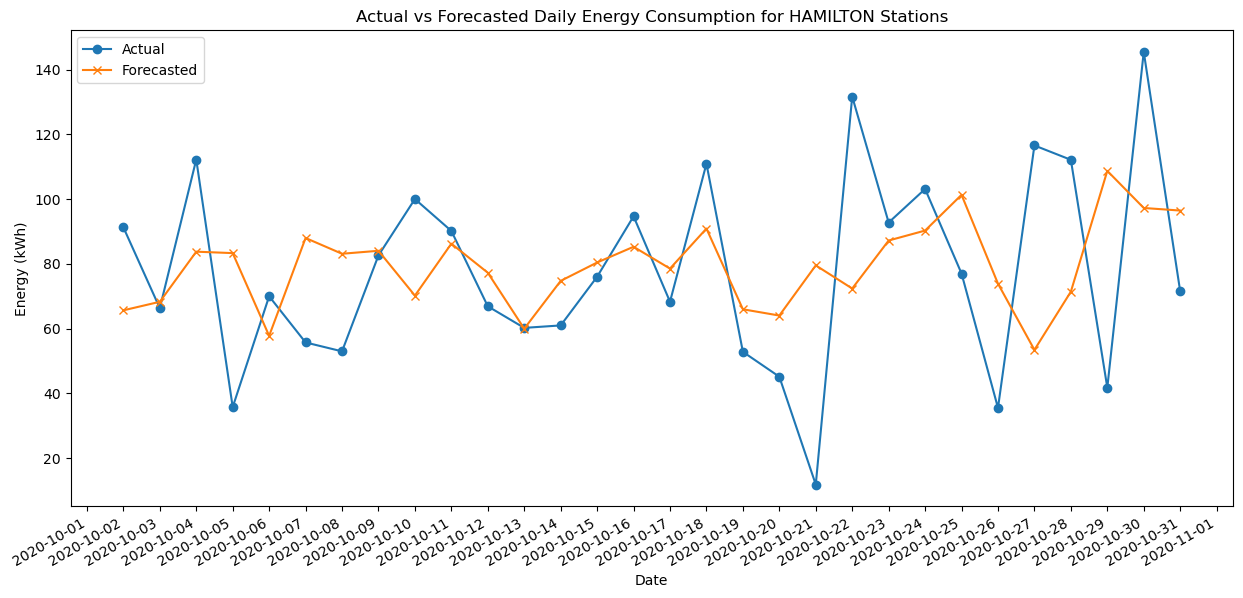

In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('EVChargingStationUsage.csv')  
# Define the function to create lagged features
def buildLaggedFeatures(s, lag=30, dropna=True):
    """
    Assumes that 's' is a pandas Series with a datetime index.
    """
    df = pd.concat([s.shift(i) for i in range(lag + 1)], axis=1)
    df.columns = ['lag_{}'.format(i) if i != 0 else s.name for i in range(lag + 1)]
    if dropna:
        df = df.dropna()
    return df

#Filter data for Hamilton stations only and convert to datetime
hamilton_data = data[data['Station Name'].str.contains('HAMILTON')]
hamilton_data['Start DateTime'] = pd.to_datetime(hamilton_data['Start Date'] + ' ' + hamilton_data['Start Time Zone'], errors='coerce')
hamilton_data.dropna(subset=['Start DateTime'], inplace=True)
#Group by date and sum the 'Energy (kWh)' for each day
daily_energy_hamilton = hamilton_data.groupby(hamilton_data['Start DateTime'].dt.floor('D'))['Energy (kWh)'].sum()

#using everything except last 30 days for training
lagged_features_hamilton = buildLaggedFeatures(daily_energy_hamilton, lag=30)
train_data_hamilton = lagged_features_hamilton.iloc[:-30]  
test_data_hamilton = lagged_features_hamilton.iloc[-30:]   

#Separate features and train Random Forest model
X_train_hamilton = train_data_hamilton.drop(columns=['Energy (kWh)'])
y_train_hamilton = train_data_hamilton['Energy (kWh)']
X_test_hamilton = test_data_hamilton.drop(columns=['Energy (kWh)'])
y_test_hamilton = test_data_hamilton['Energy (kWh)']
rf_regressor_hamilton = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor_hamilton.fit(X_train_hamilton, y_train_hamilton)
#prediction
y_pred_hamilton = rf_regressor_hamilton.predict(X_test_hamilton)
#RMSE
rmse_hamilton = sqrt(mean_squared_error(y_test_hamilton, y_pred_hamilton))
print(f'RMSE for HAMILTON Stations: {rmse_hamilton}')

#actual vs forecasted energy consumption
plt.figure(figsize=(15, 7))
plt.plot(y_test_hamilton.index, y_test_hamilton, label='Actual', marker='o')
plt.plot(y_test_hamilton.index, y_pred_hamilton, label='Forecasted', marker='x')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gcf().autofmt_xdate()  # Auto-format the dates
plt.xlabel('Date')
plt.ylabel('Energy (kWh)')
plt.title('Actual vs Forecasted Daily Energy Consumption for HAMILTON Stations')
plt.legend()
plt.show()